### Classificeren met Randomforest

Een Randomforest is een complexer model dat veel verschillende beslisbomen gebruikt. Dit model kan beter omgaan met complexere data dan het SGD model. <br>
Desondanks verwacht ik dat ook Randomforest niet geweldig zal wereken opp onze dataset, maar wel beter dan het SGD model.

In [1]:
# laden van libraries

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import sys
import tensorflow as tf

sys.path.insert(0, "..")
sys.path

# loading libraries, some settings for plots
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# directory bepalen
datadir_processed = Path("../data/processed")

# functies beschikbaar maken
from src.data import make_dataset_simple
from src.visualization import visualize
from src.visualization import visualize_simple




We maken eerst weer de datasets,

In [2]:
# data en label definiëren
data = [] 
labels = []

# met behulp van loop alle foto's in de 10 subdirectories doorlopen
for f in sorted(os.listdir(datadir_processed)):
    folder = os.path.join(datadir_processed, f)
    if os.path.isdir(folder):
        
        for i in sorted(os.listdir(folder)):
            image=tf.keras.preprocessing.image.load_img(folder+'/'+i, color_mode='grayscale', # omzetten naar 1 channel voor lineair model
            target_size= (64,64))
            image=np.array(image)
            data.append(image)
            labels.append(f)    # foldernaam als label

data = np.array(data)
labels = np.array(labels) 


# train en testset maken
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3,
                                                random_state=42)

# uitkomst checken
print(X_train.shape)
print(X_test.shape)

(12415, 64, 64)
(5321, 64, 64)


En ik zet de data weer om naar een vector.

In [3]:
# the -1 tells the method .reshape() to reshape to a matrix where the amount that should be at -1 is deducted from the other amounts.
# because the first number is 14.188, reshape will make sure the second value is 4096, because that is the only way
# to make a matrix with 14.188 rows, in this case.
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape)
print(X_test.shape)

(12415, 4096)
(5321, 4096)


In [5]:
# Data scalenom het model te helpen
X_scale = make_dataset_simple.scale(X_train)


2022-02-02 19:33:54.609 | INFO     | src.data.make_dataset_simple:scale:19 - Run standardscaler on data.


In [6]:
#model=RandomForestClassifier(n_estimators = 100, max_depth=5, min_samples_split = 100, max_leaf_nodes=25, min_samples_leaf = 250,n_jobs = 4,random_state =1)

#rf = model.fit(X_train, y_train)
#yhat = cross_val_predict(rf, X_scale, y_train, cv = 3)

In [7]:
# we make a pipe
# running will take about 4 minutes
pipe = Pipeline(
    [
        ("rfc", RandomForestClassifier(random_state=1))
    ]
)

# set a grid
param_grid = {'rfc__max_depth': np.arange(20, 60, 10),
              'rfc__n_estimators': np.arange(40, 100, 20)}

gridsearch = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=4, seed=42)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'rfc__max_depth': 40, 'rfc__n_estimators': 80}

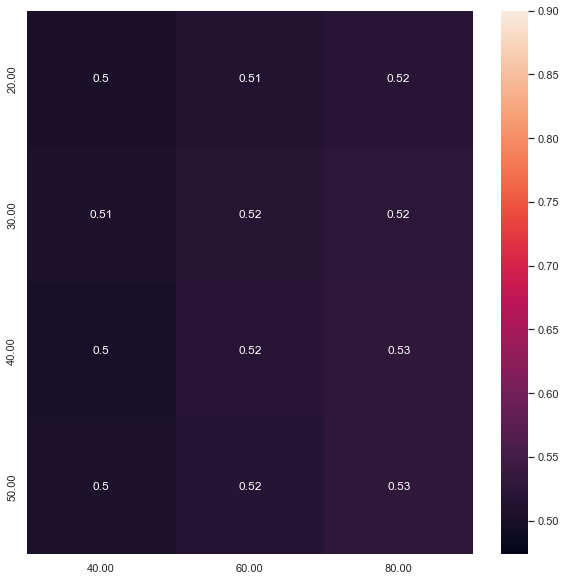

In [8]:
visualize.gridsearch_heatmap(gridsearch, param_grid, vmin = 0.9, figsize=(10,10))

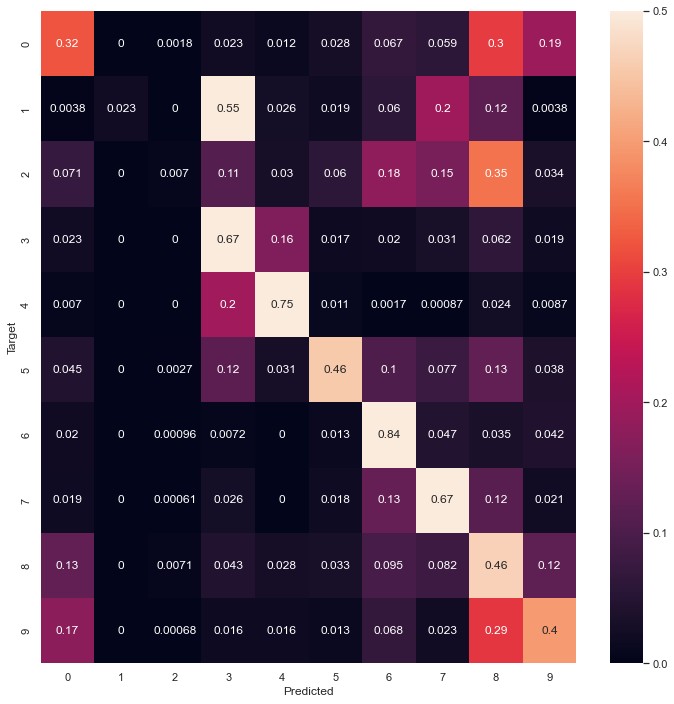

In [9]:
pipe.set_params(**gridsearch.best_params_)
rf = pipe.fit(X_train, y_train)


yhat = cross_val_predict(rf, X_scale, y_train, cv = 3)

cfm = confusion_matrix(y_train, yhat)
visualize_simple.cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.5)

In [10]:

print(classification_report(y_train,yhat))

                       precision    recall  f1-score   support

        Barred Spiral       0.41      0.32      0.36      1650
  Cigar Shaped Smooth       1.00      0.02      0.04       266
            Disturbed       0.19      0.01      0.01       863
   Edge-on with Bulge       0.54      0.67      0.60      1495
Edge-on without Bulge       0.67      0.75      0.71      1144
              Merging       0.70      0.46      0.55      1473
         Round Smooth       0.64      0.84      0.72      2082
 Smooth, Cigar shaped       0.59      0.67      0.63      1628
Unbarred Loose Spiral       0.35      0.46      0.40      2112
Unbarred Tight Spiral       0.42      0.40      0.41      1475

             accuracy                           0.53     14188
            macro avg       0.55      0.46      0.44     14188
         weighted avg       0.52      0.53      0.50     14188

